# 1. Imports

In [49]:
import numpy as np
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose


In [8]:
final_df = pd.read_pickle('Final_Data/final_features_scores.pkl')
final_df.head()
final_df.columns

Index(['id', 'electoral_term', 'session', 'first_name', 'document_url',
       'last_name', 'faction_id', 'position_short', 'position_long',
       'politician_id', 'top_item', 'top_title', 'speech_content', 'date',
       'faction', 'year', 'speech_length', 'age', 'gender', 'tenure', 'topic',
       'main_category', 'sub_category', 'Stadt', 'Former Country',
       'City Classification', 'net_sentiment_score', 'positivity_sentiment',
       'negativity_sentiment', 'polarizing'],
      dtype='object')

# 2. Total Development

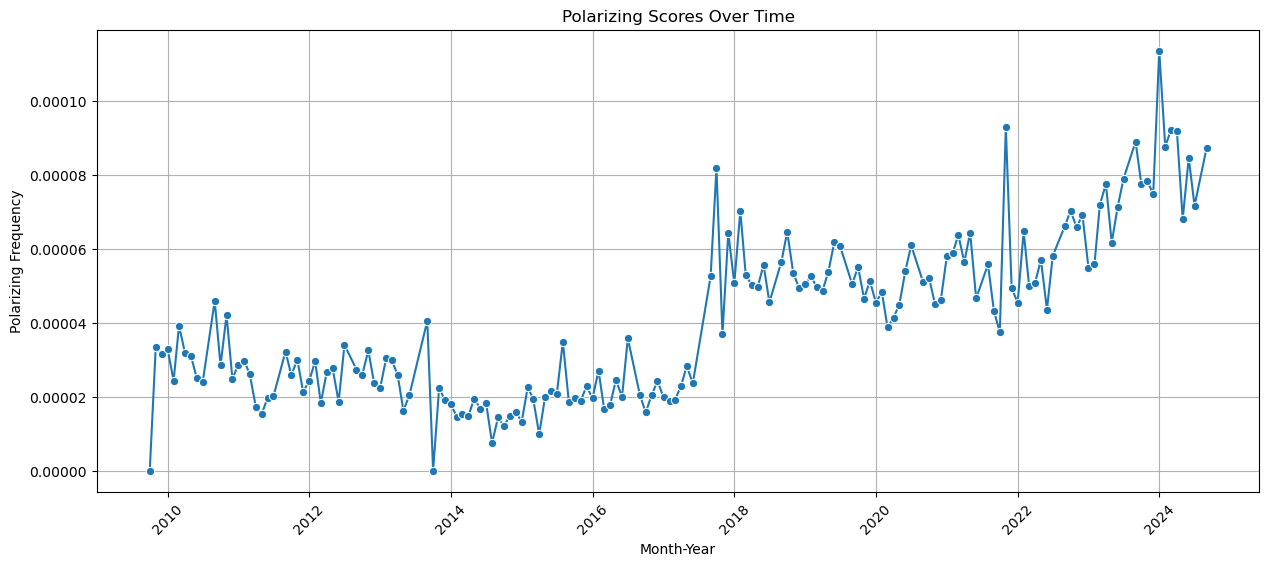

In [9]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['month_year'] = final_df['date'].dt.to_period('M')

# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
grouped = final_df.groupby('month_year').agg({'polarizing': 'sum', 'speech_length': 'sum'})
grouped['frequency'] = grouped['polarizing'] / grouped['speech_length']

# Reset index for plotting
grouped = grouped.reset_index()
grouped['month_year'] = grouped['month_year'].dt.to_timestamp()

# Plotting using seaborn for a cleaner and prettier output
plt.figure(figsize=(15, 6))
sns.lineplot(x='month_year', y='frequency', data=grouped, marker='o')
plt.title('Polarizing Scores Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Polarizing Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


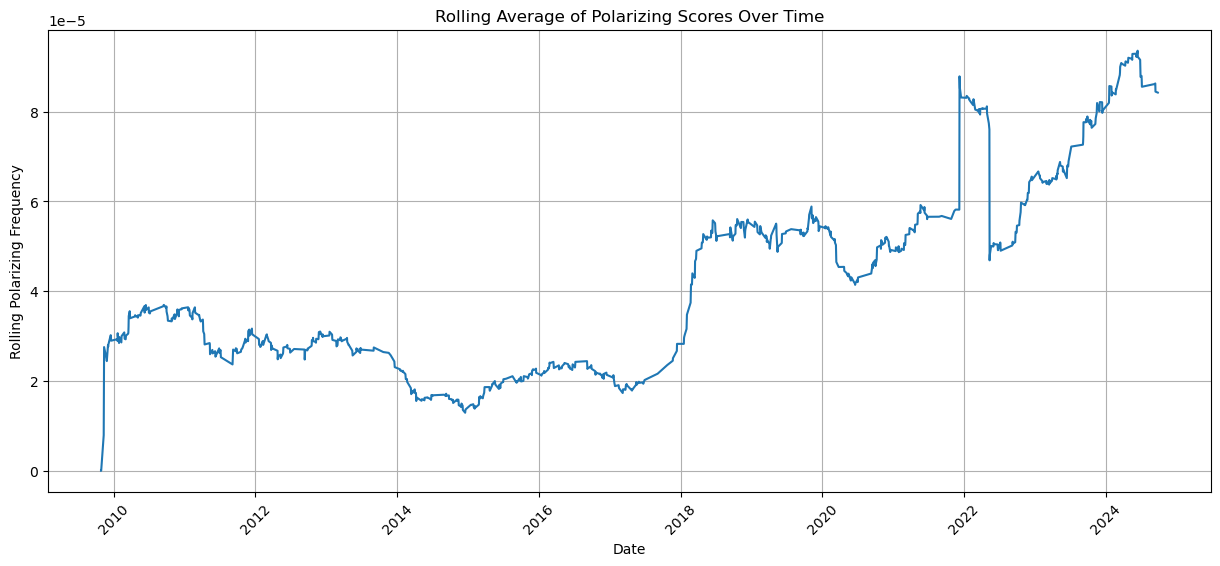

In [23]:
# Assuming 'final_df' already has the 'date' column in datetime format
final_df['date'] = pd.to_datetime(final_df['date'])

# Group by 'date', sum 'polarizing' and 'speech_length', and calculate frequency
daily_grouped = final_df.groupby('date').agg({'polarizing': 'sum', 'speech_length': 'sum'})
daily_grouped['frequency'] = daily_grouped['polarizing'] / daily_grouped['speech_length']

# Applying a 30-day rolling average for smoothing
daily_grouped['rolling_frequency'] = daily_grouped['frequency'].rolling(window=30, min_periods=1).mean()

# Resetting index for plotting
daily_grouped = daily_grouped.reset_index()

# Plotting using seaborn for a cleaner and prettier output with rolling average
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_frequency', data=daily_grouped)
plt.title('Rolling Average of Polarizing Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Development by Faction

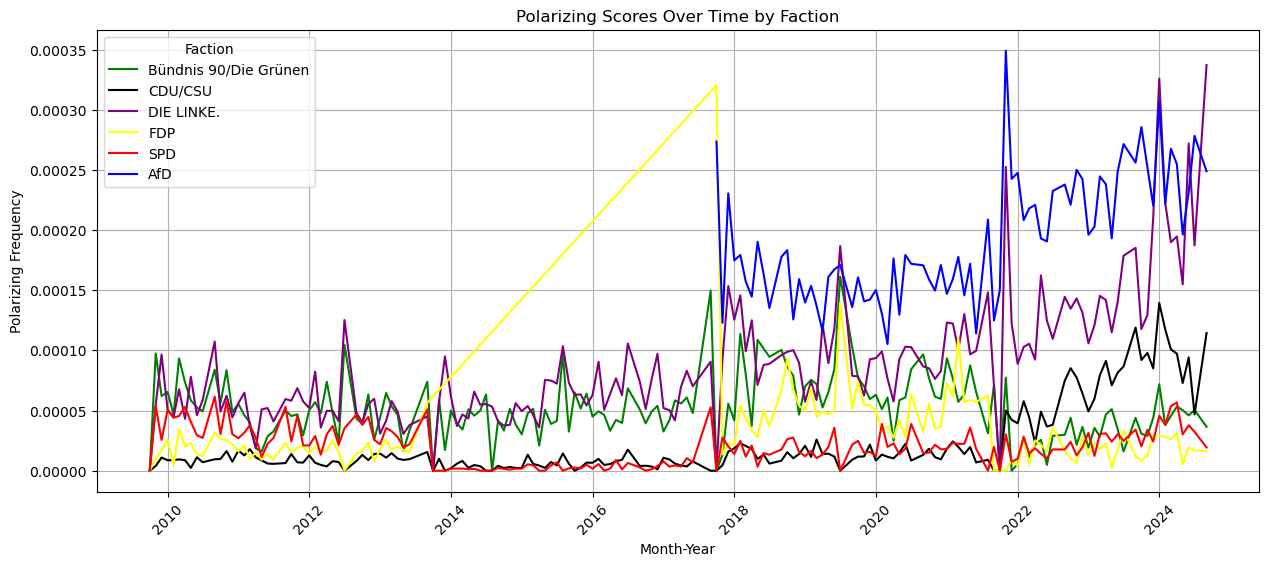

In [18]:
# Adjusting the color map to match the faction names exactly as they appear in the dataset
color_map = {
    'CDU/CSU': 'black',
    'SPD': 'red',
    'FDP': 'yellow',
    'Bündnis 90/Die Grünen': 'green',
    'DIE LINKE.': 'purple',
    'AfD': 'blue',
}

# Filtering out 'Fraktionslos' before performing any groupby operation
filtered_df = final_df[final_df['faction'] != 'Fraktionslos']

# Grouping by 'month_year' and 'faction', then calculating the polarizing frequency
faction_grouped = filtered_df.groupby(['month_year', 'faction']).agg({
    'polarizing': 'sum',
    'speech_length': 'sum'
})
faction_grouped['frequency'] = faction_grouped['polarizing'] / faction_grouped['speech_length']

# Resetting index for plotting
faction_grouped = faction_grouped.reset_index()
faction_grouped['month_year'] = faction_grouped['month_year'].dt.to_timestamp()

# Plotting polarizing frequency by faction over time with specified colors
plt.figure(figsize=(15, 6))
sns.lineplot(x='month_year', y='frequency', hue='faction', palette=color_map, data=faction_grouped)
plt.title('Polarizing Scores Over Time by Faction')
plt.xlabel('Month-Year')
plt.ylabel('Polarizing Frequency')
plt.xticks(rotation=45)
plt.legend(title='Faction')
plt.grid(True)
plt.show()


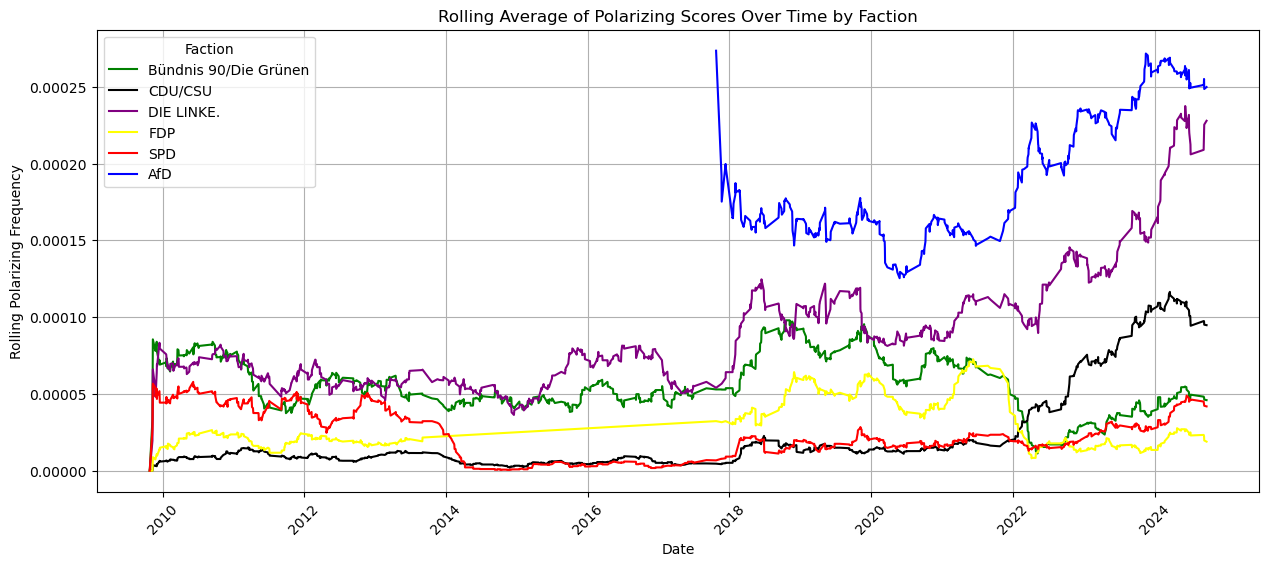

In [21]:


# Filter out 'Fraktionslos' and ensure faction names are correct in the dataframe
filtered_df = final_df[(final_df['faction'] != 'Fraktionslos')]

# Grouping by 'date' and 'faction', then calculating the polarizing frequency
faction_grouped = filtered_df.groupby(['date', 'faction']).agg({
    'polarizing': 'sum',
    'speech_length': 'sum'
})
faction_grouped['frequency'] = faction_grouped['polarizing'] / faction_grouped['speech_length']

# Resetting index for plotting
faction_grouped = faction_grouped.reset_index()
faction_grouped['date'] = pd.to_datetime(faction_grouped['date'])

# Applying a 30-day rolling average for smoothing, grouped by faction
faction_grouped['rolling_frequency'] = faction_grouped.groupby('faction')['frequency'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plotting rolling average of polarizing frequency by faction over time with specified colors
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_frequency', hue='faction', palette=color_map, data=faction_grouped)
plt.title('Rolling Average of Polarizing Scores Over Time by Faction')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.legend(title='Faction')
plt.grid(True)
plt.show()


Not Frequency but totals:

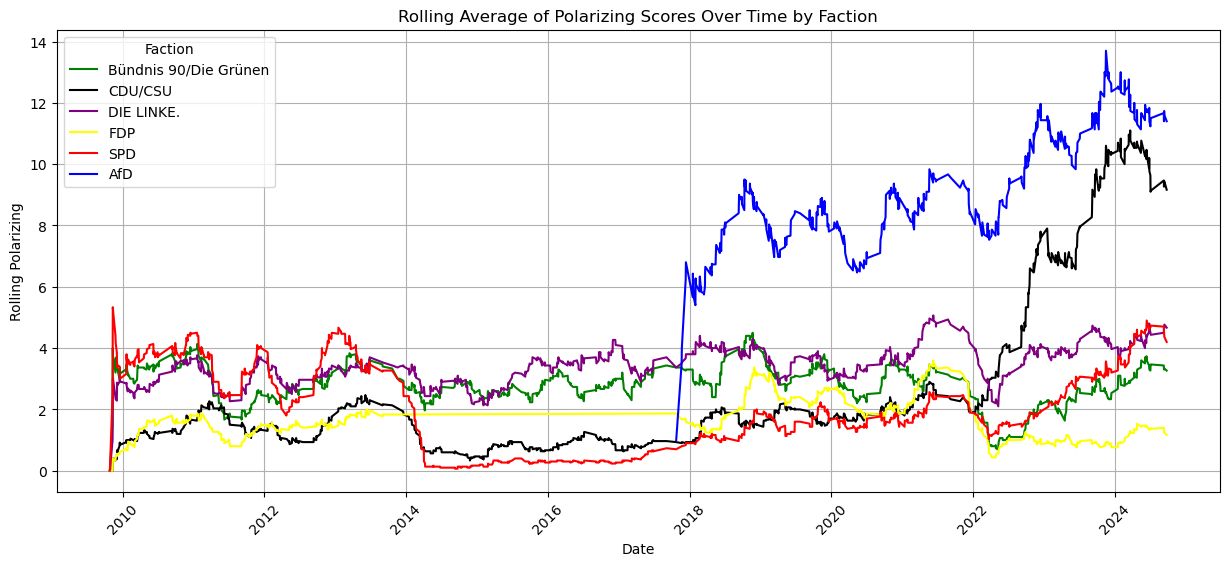

In [36]:

faction_grouped['rolling_polarizing'] = faction_grouped.groupby('faction')['polarizing'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plotting rolling average of polarizing frequency by faction over time with specified colors
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_polarizing', hue='faction', palette=color_map, data=faction_grouped)
plt.title('Rolling Average of Polarizing Scores Over Time by Faction')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing')
plt.xticks(rotation=45)
plt.legend(title='Faction')
plt.grid(True)
plt.show()

Percentage change per electoral term per faction

In [40]:

final_df['frequency'] = final_df['polarizing'] / final_df['speech_length']

# Aggregate data to get the average frequency per electoral term and faction
avg_freq_per_term_faction = final_df.groupby(['electoral_term', 'faction'])['frequency'].mean().reset_index()

# Pivot the data to have electoral terms as rows and factions as columns
pivot_avg_freq_faction = avg_freq_per_term_faction.pivot(index='electoral_term', columns='faction', values='frequency')

# Calculate the percentage change from the previous electoral term for each faction
percentage_change_faction = pivot_avg_freq_faction.pct_change() * 100

# Display the result
print("Average Frequency per Electoral Term by Faction:")
print(pivot_avg_freq_faction)
print("\nPercentage Change from Previous Electoral Term:")
print(percentage_change_faction)


Average Frequency per Electoral Term by Faction:
faction              AfD  Bündnis 90/Die Grünen   CDU/CSU  DIE LINKE.  \
electoral_term                                                          
17                   NaN               0.000155  0.000053    0.000140   
18                   NaN               0.000105  0.000031    0.000137   
19              0.000435               0.000235  0.000065    0.000222   
20              0.000861               0.000177  0.000348    0.000396   

faction              FDP  Fraktionslos       SPD  
electoral_term                                    
17              0.000053      0.000148  0.000185  
18                   NaN      0.000351  0.000020  
19              0.000140      0.000372  0.000119  
20              0.000093      0.001704  0.000169  

Percentage Change from Previous Electoral Term:
faction               AfD  Bündnis 90/Die Grünen     CDU/CSU  DIE LINKE.  \
electoral_term                                                             
17   

# 4. Development by Faction vs. Coalition

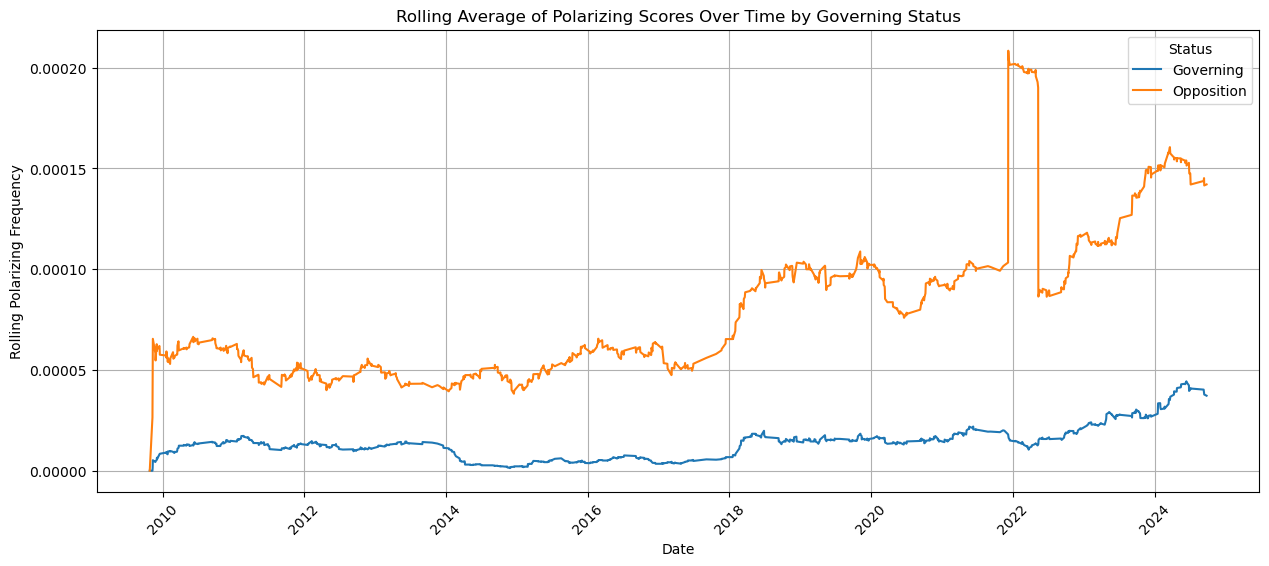

In [29]:
# Assuming 'final_df' is updated to include the 'electoral_term' column
# Define the mapping from electoral terms to governing factions
regierung_mapping = {
    17: ['CDU/CSU', 'FDP'],
    18: ['CDU/CSU', 'SPD'],
    19: ['CDU/CSU', 'SPD'],
    20: ['SPD', 'FDP', 'Bündnis 90/Die Grünen']
}

# Function to assign 'Governing' or 'Opposition' status based on the mapping
def map_governing_faction(row):
    governing_factions = regierung_mapping.get(row['electoral_term'], [])
    return 'Governing' if row['faction'] in governing_factions else 'Opposition'

# Apply the function to create a new 'status' column in final_df
final_df['status'] = final_df.apply(map_governing_faction, axis=1)

# Group by 'date' and 'status', then calculate the polarizing frequency
grouped_by_status = final_df.groupby(['date', 'status']).agg({
    'polarizing': 'sum',
    'speech_length': 'sum'
})
grouped_by_status['frequency'] = grouped_by_status['polarizing'] / grouped_by_status['speech_length']

# Reset index for plotting
grouped_by_status = grouped_by_status.reset_index()
grouped_by_status['date'] = pd.to_datetime(grouped_by_status['date'])

# Applying a 30-day rolling average for smoothing, grouped by status
grouped_by_status['rolling_frequency'] = grouped_by_status.groupby('status')['frequency'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plotting the rolling average of polarizing frequency by governing status over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_frequency', hue='status', data=grouped_by_status)
plt.title('Rolling Average of Polarizing Scores Over Time by Governing Status')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.legend(title='Status')
plt.grid(True)
plt.show()


In [30]:

# Calculate the polarizing frequency
final_df['frequency'] = final_df['polarizing'] / final_df['speech_length']

# Aggregate data to get the average frequency per electoral term and status
avg_freq_per_term_status = final_df.groupby(['electoral_term', 'status'])['frequency'].mean().reset_index()

# Pivot the data to have electoral terms as rows and status as columns
pivot_avg_freq = avg_freq_per_term_status.pivot(index='electoral_term', columns='status', values='frequency')

# Calculate the percentage change from the previous electoral term for each status
percentage_change = pivot_avg_freq.pct_change() * 100

# Display the result
print("Average Frequency per Electoral Term by Status:")
print(pivot_avg_freq)
print("\nPercentage Change from Previous Electoral Term:")
print(percentage_change)


Average Frequency per Electoral Term by Status:
status          Governing  Opposition
electoral_term                       
17               0.000053    0.000164
18               0.000026    0.000118
19               0.000086    0.000257
20               0.000153    0.000478

Percentage Change from Previous Electoral Term:
status           Governing  Opposition
electoral_term                        
17                     NaN         NaN
18              -51.238918  -28.223137
19              229.222690  118.900660
20               77.856088   85.998539


Correlation

In [33]:
import pandas as pd

# Assuming 'final_df' is your DataFrame and it already includes the 'status' and 'frequency' columns
# Map 'status' to numeric values: 'Governing' = 1 and 'Opposition' = 0
final_df['status_numeric'] = final_df['status'].map({'Governing': 1, 'Opposition': 0})

# Calculate the correlation between the numeric status and polarizing frequency
correlation = final_df['status_numeric'].corr(final_df['frequency'])

# Print the correlation coefficient
print("Correlation between governing status and polarizing frequency:", correlation)


Correlation between governing status and polarizing frequency: -0.0594487942881247


# 5. Most significant changes

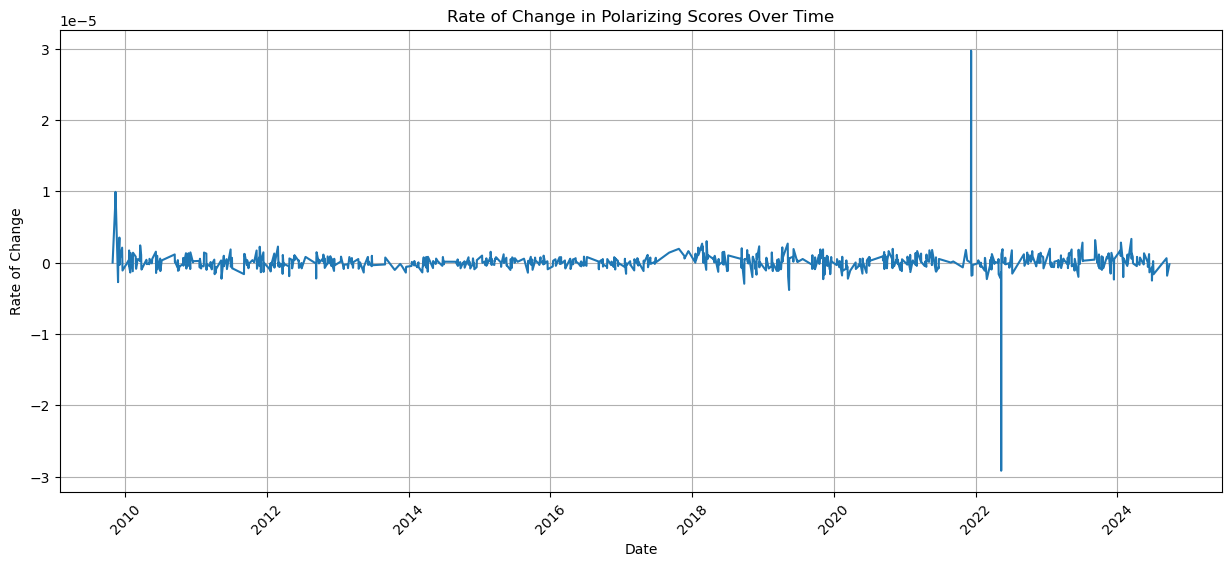

Top 10 Rises in Polarizing Scores:
          date  rate_of_change
738 2021-12-08        0.000030
4   2009-11-12        0.000010
3   2009-11-11        0.000010
2   2009-11-10        0.000008
7   2009-12-02        0.000004
889 2024-03-13        0.000003
853 2023-09-08        0.000003
515 2018-03-16        0.000003
881 2024-01-19        0.000003
847 2023-07-05        0.000003

Bottom 10 Falls in Polarizing Scores:
          date  rate_of_change
107 2011-05-12       -0.000002
752 2022-02-27       -0.000002
618 2019-11-07       -0.000002
877 2023-12-14       -0.000002
911 2024-06-27       -0.000003
5   2009-11-25       -0.000003
545 2018-09-26       -0.000003
594 2019-05-15       -0.000004
768 2022-05-12       -0.000029
0   2009-10-27             NaN


In [27]:

# Calculate the rate of change in polarizing scores
daily_grouped['rate_of_change'] = daily_grouped['rolling_frequency'].diff()

# Sorting the DataFrame by the rate of change to find significant changes
sorted_changes = daily_grouped.sort_values(by='rate_of_change', ascending=False)

# Select the top 5 rises and bottom 5 falls in polarizing scores
top_5_rises = sorted_changes.head(10)
bottom_5_falls = sorted_changes.tail(10)

# Plotting the rate of change
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rate_of_change', data=daily_grouped)
plt.title('Rate of Change in Polarizing Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Rate of Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Displaying th

print("Top 10 Rises in Polarizing Scores:")
print(top_5_rises[['date', 'rate_of_change']])
print("\nBottom 10 Falls in Polarizing Scores:")
print(bottom_5_falls[['date', 'rate_of_change']])

# 6. The role of elections

## 6.1 Rate of change before elections

Calculation of the rate of change two month prior and post electoins

In [47]:


# Provided election dates
election_dates = pd.to_datetime(['2009-09-27', '2013-09-22', '2017-09-24', '2021-09-26'])

# Initialize an empty DataFrame for the results
results = []

# Iterate through each election date
for date in election_dates:
    # Calculate the date ranges for two months before and after the election
    pre_election_start = date - pd.DateOffset(months=2)
    post_election_end = date + pd.DateOffset(months=2)

    # Filter data for the two months before and after the election
    pre_election_data = final_df[(final_df['date'] >= pre_election_start) & (final_df['date'] < date)]
    post_election_data = final_df[(final_df['date'] > date) & (final_df['date'] <= post_election_end)]

    # Calculate the average frequency for each period
    pre_avg = pre_election_data['frequency'].mean()
    post_avg = post_election_data['frequency'].mean()

    # Calculate the percentage change
    if pre_avg != 0:  # Avoid division by zero
        percent_change = ((post_avg - pre_avg) / pre_avg) * 100
    else:
        percent_change = None  # Handle cases where pre_avg is zero

    # Append the results
    results.append({
        'Election Year': date.year,
        'Pre-Election Average Frequency': pre_avg,
        'Post-Election Average Frequency': post_avg,
        'Percentage Change': percent_change
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


   Election Year  Pre-Election Average Frequency  \
0           2009                             NaN   
1           2013                        0.000158   
2           2017                        0.000719   
3           2021                        0.000145   

   Post-Election Average Frequency  Percentage Change  
0                         0.000073                NaN  
1                         0.000142         -10.131938  
2                         0.000088         -87.812955  
3                         0.000459         216.144609  


Changes in polarization one month prior and post election

In [48]:


# Provided election dates
election_dates = pd.to_datetime(['2009-09-27', '2013-09-22', '2017-09-24', '2021-09-26'])

# Initialize an empty DataFrame for the results
results = []

# Iterate through each election date
for date in election_dates:
    # Calculate the date ranges for two months before and after the election
    pre_election_start = date - pd.DateOffset(months=1)
    post_election_end = date + pd.DateOffset(months=1)

    # Filter data for the two months before and after the election
    pre_election_data = final_df[(final_df['date'] >= pre_election_start) & (final_df['date'] < date)]
    post_election_data = final_df[(final_df['date'] > date) & (final_df['date'] <= post_election_end)]

    # Calculate the average frequency for each period
    pre_avg = pre_election_data['frequency'].mean()
    post_avg = post_election_data['frequency'].mean()

    # Calculate the percentage change
    if pre_avg != 0:  # Avoid division by zero
        percent_change = ((post_avg - pre_avg) / pre_avg) * 100
    else:
        percent_change = None  # Handle cases where pre_avg is zero

    # Append the results
    results.append({
        'Election Year': date.year,
        'Pre-Election Average Frequency': pre_avg,
        'Post-Election Average Frequency': post_avg,
        'Percentage Change': percent_change
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


   Election Year  Pre-Election Average Frequency  \
0           2009                             NaN   
1           2013                        0.000158   
2           2017                        0.000719   
3           2021                        0.000091   

   Post-Election Average Frequency  Percentage Change  
0                         0.000000                NaN  
1                         0.000000        -100.000000  
2                         0.000074         -89.672184  
3                         0.000017         -81.298241  


# 7. Time series Analysis

## 7.1 Sesonal Decomposition

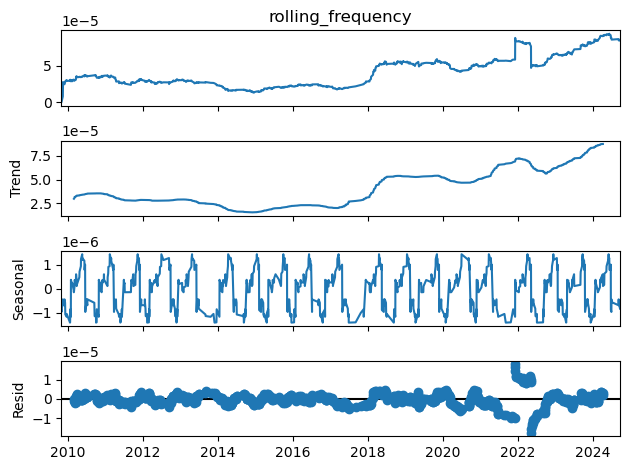

In [53]:
# Ensure your date column is in datetime format and set as the index
#daily_grouped['date'] = pd.to_datetime(daily_grouped['date'])
#daily_grouped.set_index('date', inplace=True)

# Decompose the time series
result = seasonal_decompose(daily_grouped['rolling_frequency'], model='additive', period=48)  # Assuming monthly data; adjust the period accordingly

# Plot the decomposed components
result.plot()
plt.show()

      Year  Percentage Change
0   2010.0          16.516665
1   2011.0         -17.289223
2   2012.0           1.742879
3   2013.0         -20.254016
4   2014.0         -32.266390
5   2015.0          42.442028
6   2016.0          -7.619420
7   2017.0          50.837537
8   2018.0          69.731930
9   2019.0          -2.072527
10  2020.0          -2.871258
11  2021.0          41.463166
12  2022.0         -14.344392
13  2023.0          33.932758
14  2024.0           4.600320


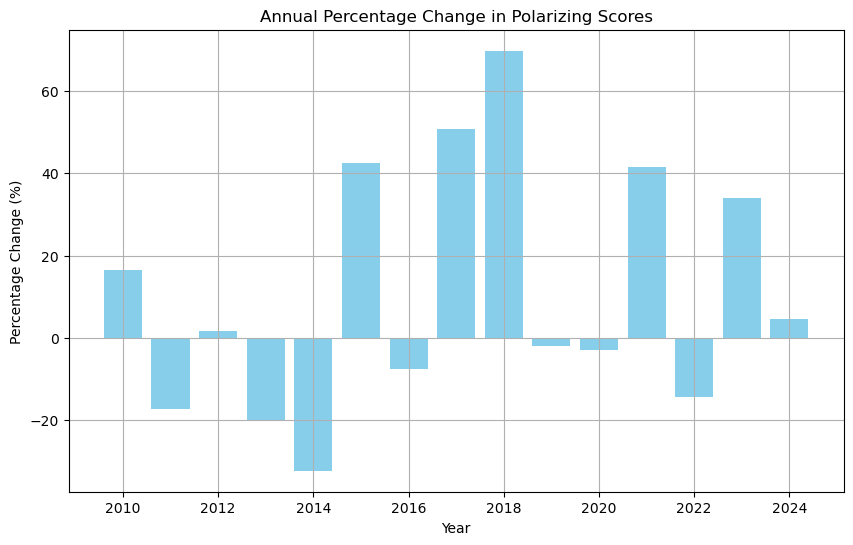

In [61]:
# Ensure the trend data is already prepared
trend_data = result.trend.dropna()  # Assuming result.trend is your trend component
trend_data.index = pd.to_datetime(trend_data.index)  # Ensure datetime index

# Initialize a DataFrame to hold the results
annual_percentage_changes = pd.DataFrame(columns=['Year', 'Percentage Change'])

# Calculate percentage changes for each year
for year in np.unique(trend_data.index.year):
    yearly_data = trend_data[trend_data.index.year == year]
    if not yearly_data.empty:
        start_value = yearly_data.iloc[0]  # First value of the year
        end_value = yearly_data.iloc[-1]   # Last value of the year

        # Calculate percentage change from start to end of the year
        if start_value != 0:  # Avoid division by zero
            percentage_change = ((end_value - start_value) / start_value) * 100
            annual_percentage_changes = annual_percentage_changes.append({
                'Year': year,
                'Percentage Change': percentage_change
            }, ignore_index=True)

# Display the results
print(annual_percentage_changes)

# Convert 'Year' to integer for plotting
annual_percentage_changes['Year'] = annual_percentage_changes['Year'].astype(int)

plt.figure(figsize=(10, 6))
plt.bar(annual_percentage_changes['Year'], annual_percentage_changes['Percentage Change'], color='skyblue')
plt.title('Annual Percentage Change in Polarizing Scores')
plt.xlabel('Year')
plt.ylabel('Percentage Change (%)')
plt.grid(True)
plt.show()

In [59]:
# Assuming the trend data has already been loaded and prepared
x = np.array(trend_data.index.to_julian_date())  # Convert dates to numerical format
y = trend_data.values

# Fit a linear regression to the entire dataset
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Convert slope to annual slope assuming the x-axis is in Julian dates (365.25 days per year)
annual_slope = slope * 365.25

# Display the annualized slope
print(f"Annualized Slope: {annual_slope:.5f}")
print(f"R-squared: {r_value**2:.5f}")
print(f"P-value: {p_value:.5f}")

Annualized Slope: 0.00000
R-squared: 0.64798
P-value: 0.00000


## 7.2 Fourier

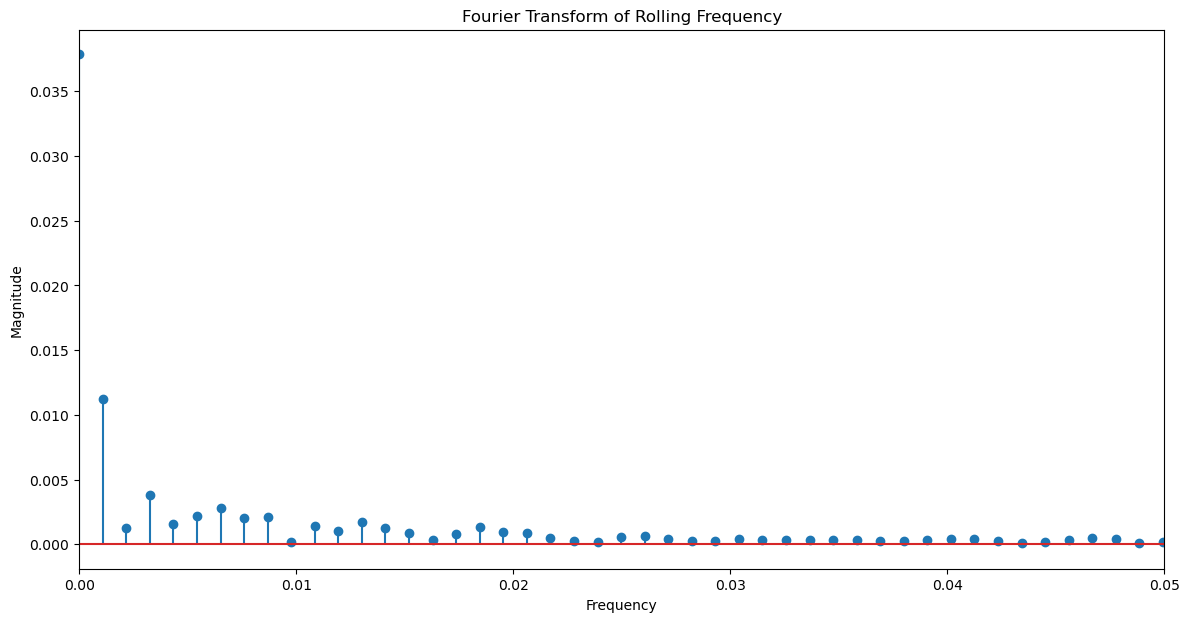

In [54]:
# Perform a Fourier transform
fft_result = np.fft.fft(daily_grouped['rolling_frequency'].dropna())

# Get frequencies and magnitudes
frequencies = np.fft.fftfreq(len(fft_result))
magnitudes = np.abs(fft_result)

# Plot the spectrum
plt.figure(figsize=(14, 7))
plt.stem(frequencies, magnitudes)
plt.title('Fourier Transform of Rolling Frequency')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim([0, 0.05])  # Adjust x-axis limits to focus on lower frequencies, which corresponds to longer cycles
plt.show()


No Clear Peaks at Expected Electoral Frequencies: If there are no distinct peaks at the frequencies corresponding to known electoral cycles (e.g., 4-year cycles would correspond to a frequency of about 0.25 if data were annual, less frequent if data points are monthly), it might suggest that electoral cycles do not have a strong or clear impact on the pattern of polarization observed in the data.

## 7.3 Auto correlation

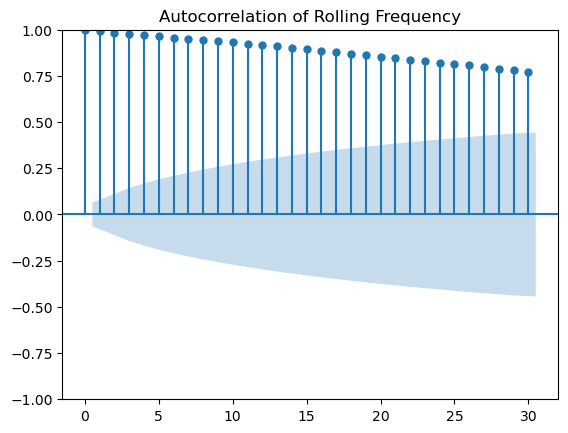

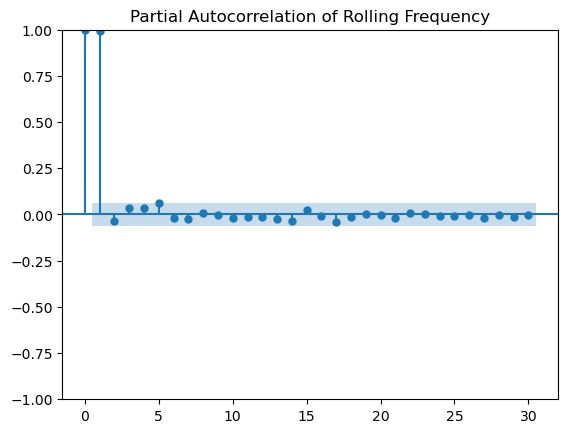

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation
plot_acf(daily_grouped['rolling_frequency'])
plt.title('Autocorrelation of Rolling Frequency')
plt.show()

# Plot partial autocorrelation
plot_pacf(daily_grouped['rolling_frequency'])
plt.title('Partial Autocorrelation of Rolling Frequency')
plt.show()


## 7.5 ARIMA and SARIMA

In [62]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test to check for stationarity
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Assuming 'daily_grouped' has 'rolling_frequency' as your series
test_stationarity(daily_grouped['rolling_frequency'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -1.153225
p-value                          0.693387
#Lags Used                       0.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


In [63]:
# Differencing the series
daily_grouped['diff_rolling_frequency'] = daily_grouped['rolling_frequency'].diff()

# Drop any NaNs that resulted from differencing
daily_grouped.dropna(inplace=True)

# Check stationarity again with the Dickey-Fuller test
test_stationarity(daily_grouped['diff_rolling_frequency'])


Results of Dickey-Fuller Test:
Test Statistic                 -28.361344
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [64]:
# Seasonal differencing (assuming monthly data, so a 4-year cycle would be 48 months)
daily_grouped['seasonal_diff'] = daily_grouped['rolling_frequency'].diff(48)

# Drop any NaNs that resulted from differencing
daily_grouped.dropna(inplace=True)

# Check stationarity again
test_stationarity(daily_grouped['seasonal_diff'])


Results of Dickey-Fuller Test:
Test Statistic                  -5.081668
p-value                          0.000015
#Lags Used                      18.000000
Number of Observations Used    853.000000
Critical Value (1%)             -3.438039
Critical Value (5%)             -2.864934
Critical Value (10%)            -2.568577
dtype: float64


In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'rolling_frequency' is your series
# Ensure your series is stationary (difference if not already done)
daily_grouped['diff_rolling_frequency'] = daily_grouped['rolling_frequency'].diff().dropna()

# Fit the ARIMA model
model = SARIMAX(daily_grouped['diff_rolling_frequency'],
                order=(1, 0, 0),    # ARIMA(1,0,0)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Print out the summary of the model
print(results.summary())


/Users/Silja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Silja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05520D+01    |proj g|=  6.81425D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   6.814D+04  -1.055D+01
  F =  -10.551995158688491     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/Silja/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 SARIMAX Results                                  
Dep. Variable:     diff_rolling_frequency   No. Observations:                  872
Model:                   SARIMAX(1, 0, 0)   Log Likelihood                9201.340
Date:                    Sat, 23 Nov 2024   AIC                         -18398.680
Time:                            16:34:29   BIC                         -18389.140
Sample:                                 0   HQIC                        -18395.030
                                    - 872                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0153   2.22e-23   6.89e+20      0.000       0.015       0.015
sigma2          1e-10   6.73e-11      1.487      0.137   -3.18e-11    2.32e-10
Ljung-Box (L1) (Q): 